<a href="https://colab.research.google.com/github/omkarsarde/DistributedAnalysisOfML/blob/main/GPU8G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Scaling
# Device: GPU
# Memory: 8 GB

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5650b50b-57ef-0dfa-053b-1661d0b27bce)


In [2]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow import keras
import time
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 8GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:

# Load the dataset directly from tensorflow
pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

In [5]:
# Split the dataset into train, test and validation sets
train_data = pcam['train']
test_data = pcam['test']
valid_data = pcam['validation']

In [6]:
# Preprocess the data
# data is in uint8, convert to float32
# also as we are using a off the shelf model, one hot encode the label
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [7]:
# Preprocess the split datasets using the preprocessing function we defined
train_data = train_data.map(convert_sample)
valid_data = valid_data.map(convert_sample)
test_data = test_data.map(convert_sample)

In [8]:
# Create batches for training testing and validation
# Set a buffer size for shuffling of training data
# Setting batch_size of 128 as batch size of 256 and above is causing overflow for training data
buffer_size = 1000
batch_size = 128
train_data_batch = train_data.batch(batch_size).shuffle(buffer_size).prefetch(2)
valid_data_batch = valid_data.batch(batch_size*2).prefetch(2)
test_data_batch = test_data.batch(batch_size*2).prefetch(2)

In [9]:
# STANDARD VGG16 Model
standard_Model = VGG16()
standard_Model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
standard_Model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [10]:
# Vgg16 based model We will Use
# THIS MODEL IS NOT PRETRAINED
new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [11]:
# Class to log times per epoch as 
# we will use TIME based comparison between hardware
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [12]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
history = model.fit(train_data_batch, epochs = 5, callbacks=[ time_callback], validation_data = valid_data_batch, verbose=1)

Epoch 1/5
   6/2048 [..............................] - ETA: 5:34 - loss: 0.6931 - acc: 0.5299WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0511s vs `on_train_batch_end` time: 0.0944s). Check your callbacks.


2048/2048 [==============================] - 435s 173ms/step - loss: 0.4098 - acc: 0.8023 - val_loss: 0.3375 - val_acc: 0.8500
Epoch 2/5
2048/2048 [==============================] - 429s 170ms/step - loss: 0.2228 - acc: 0.9120 - val_loss: 0.2908 - val_acc: 0.8790
Epoch 3/5
2048/2048 [==============================] - 426s 169ms/step - loss: 0.1627 - acc: 0.9391 - val_loss: 0.3226 - val_acc: 0.8761
Epoch 4/5
2048/2048 [==============================] - 427s 169ms/step - loss: 0.1332 - acc: 0.9519 - val_loss: 0.3580 - val_acc: 0.8701
Epoch 5/5
2048/2048 [==============================] - 427s 170ms/step - loss: 0.1121 - acc: 0.9599 - val_loss: 0.4605 - val_acc: 0.8563


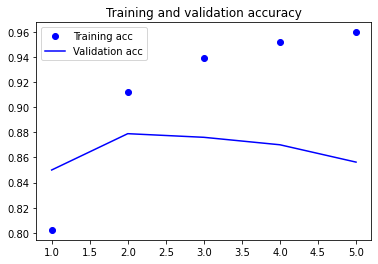

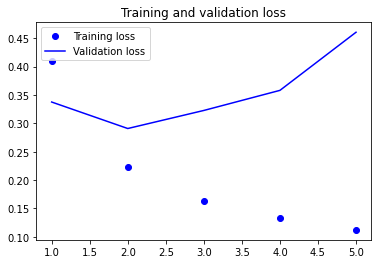

In [13]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
# Time per epoch  in seconds
time_callback.times

[435.43668031692505,
 428.5452239513397,
 426.12172389030457,
 426.70924711227417,
 426.7791209220886]

In [15]:
# Model performance on Test Data
model.evaluate(test_data_batch, verbose=1)

128/128 [==============================] - 18s 136ms/step - loss: 0.5884 - acc: 0.8255


[0.5884257555007935, 0.825531005859375]

In [16]:
# Model performance on Test Data
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_data_batch, verbose=0)[1]))

Test set accuracy is 0.8255


In [17]:
# Retrain the model using a smaller batch size of 64
buffer_size = 1000
batch_size = 64
train_data_batch = train_data.batch(batch_size).shuffle(buffer_size).prefetch(2)
valid_data_batch = valid_data.batch(batch_size*2).prefetch(2)
test_data_batch = test_data.batch(batch_size*2).prefetch(2)

In [18]:
# Vgg16 based model We will Use

new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [19]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback64 = TimeHistory()
history64 = model.fit(train_data_batch, epochs = 5, callbacks=[ time_callback64], validation_data = valid_data_batch, verbose=1)

Epoch 1/5
   6/4096 [..............................] - ETA: 6:00 - loss: 0.6933 - acc: 0.5339WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0320s vs `on_train_batch_end` time: 0.0471s). Check your callbacks.


4096/4096 [==============================] - 425s 92ms/step - loss: 0.3687 - acc: 0.8350 - val_loss: 0.3449 - val_acc: 0.8560
Epoch 2/5
4096/4096 [==============================] - 422s 92ms/step - loss: 0.1982 - acc: 0.9236 - val_loss: 0.3120 - val_acc: 0.8774
Epoch 3/5
4096/4096 [==============================] - 421s 91ms/step - loss: 0.1470 - acc: 0.9462 - val_loss: 0.3478 - val_acc: 0.8612
Epoch 4/5
4096/4096 [==============================] - 420s 91ms/step - loss: 0.1203 - acc: 0.9573 - val_loss: 0.3305 - val_acc: 0.8733
Epoch 5/5
4096/4096 [==============================] - 420s 91ms/step - loss: 0.1004 - acc: 0.9649 - val_loss: 0.3865 - val_acc: 0.8740


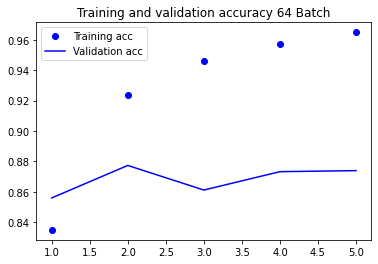

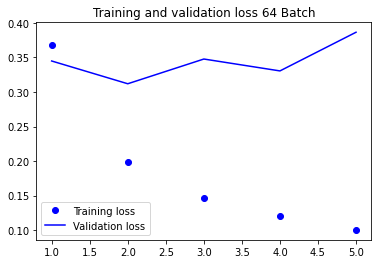

In [20]:
# Model Statistics
acc = history64.history['acc']
val_acc = history64.history['val_acc']
loss = history64.history['loss']
val_loss = history64.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 64 Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 64 Batch')
plt.legend()
plt.show()

In [21]:
# Time per epoch in seconds
time_callback64.times

[424.67210125923157,
 422.1119611263275,
 420.64607644081116,
 419.8269202709198,
 420.18476486206055]

In [22]:
# Model performance on Test Data
model.evaluate(test_data_batch, verbose=1)

256/256 [==============================] - 12s 48ms/step - loss: 0.6737 - acc: 0.8137


[0.6737477779388428, 0.813720703125]

In [23]:

# Model performance on Test Data
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_data_batch, verbose=0)[1]))

Test set accuracy is 0.8137
